In [81]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import os

In [82]:
# Class map
class_map = {
    0: 'Airplane',
    1: 'Autombile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck',
}

In [83]:
BATCH_SIZE = 64
INPUT_SHAPE = [32, 32, 3]
EPOCHS = 100

In [84]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
      if epoch < self.warmup_steps:
        return self.get_warmup_lr(epoch)
      if epoch <= self.max_update:
        self.base_lr = self.final_lr + (
                          self.base_lr_orig - self.final_lr) * (1 + math.cos(
                          math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

In [85]:
## Mout your google drive
from google.colab import drive
## mount location
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load the TF record dataset

In [86]:
## The path where the tf record file is
# file_name = '/content/drive/My Drive/public_data/cifar_10/cifar_10_data_dataset_api.tfrecords'
## Load the raw tf record file from the file system
# raw_image_dataset = tf.data.TFRecordDataset(file_name)
# print(raw_image_dataset) ## gives no much information since the parsing of a tfrecord file is not yet implemented
## To parse a tfrecord file, one needs the structure of the record file (How the data is structured when they are saved)

In [87]:
def decode_image(image, height, width, depth):
    image = tf.io.decode_raw(image, out_type=tf.uint8)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, depth]) 
    return image

In [88]:
## Make the structure that would help us to parse the TFRecord file
## feature descriptor dict
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [89]:
## Now we make a function that an iterator can take as an higher oder function
def _parser_image_function(example_proto):
    ## Parse a single image feature structure
    ## serialized byte --> _parser_image_function(feature description) --> parsed image structure (see image_example function)
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    image_decoded = decode_image(example['image_raw'], 32, 32, 3)
    label = example['label']

    return image_decoded, label

In [90]:
def load_dataset(filepath):
  # Make a dataset option object to autotune the dataloading for perfomances
  options = tf.data.Options()
  options.autotune.enabled = True
  # Load the tf record dataset
  raw_image_dataset = tf.data.TFRecordDataset(filepath)
  # set the enabled option for the dataset
  raw_image_dataset.with_options(options)
  # Parse the dataset and return
  parsed_image_dataset = raw_image_dataset.map(_parser_image_function)
  
  return parsed_image_dataset

In [91]:
AUTOTUNE = tf.data.experimental.AUTOTUNE ## Auto tune tf.data hyper parameters for 

def prepare_for_training(filepath, cache=False, shuffle_buffer_size=1000):
  ds = load_dataset(filepath)
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
      if isinstance(cache, str): ## if caching to a file
          ds = ds.cache(cache)
      else: ## cache in memory
          ds = ds.cache()
  ## shuffle data, otherwise, data will be cached with the same patten (not random)
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever (Reinitialise the dataset after each training iteration)
  # ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [92]:
## To prevent the model from becoming worst (e.g. overfitting) stop the training before the issues start using the Early stopping callback
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
#                                                      restore_best_weights=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "cifar_model.h5", save_best_only=True
)

initial_learning_rate = 0.01
scheduler = CosineScheduler(max_update=EPOCHS, base_lr=0.001, final_lr=1e-5)
lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=1
)

METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    #tf.keras.metrics.Precision(name='precision'),
    #tf.keras.metrics.Recall(name='recall'),
    # tf.keras.metrics.AUC(name="auc")
]

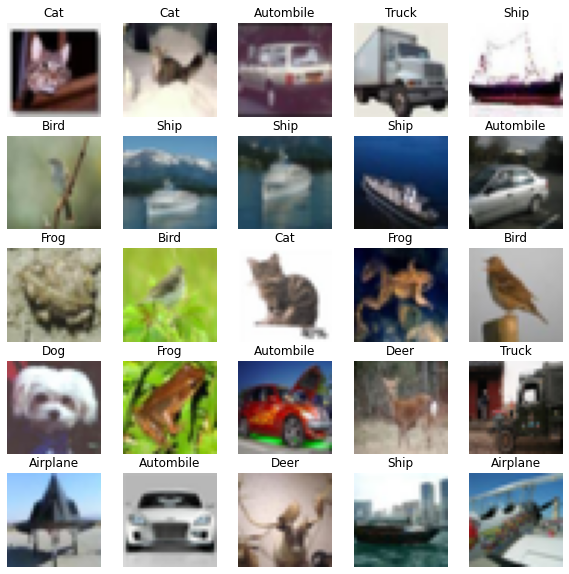

In [93]:
# Single tfrecords
# train_ds = prepare_for_training('/content/drive/My Drive/public_data/cifar_10/train/cifar_10_data_dataset_api.tfrecords')
# Multiple tfrecords
folder_path = '/content/drive/My Drive/public_data/cifar_10/train_records'
record_list = glob.glob(os.path.join(folder_path, '*.tfrecords'))
train_ds = prepare_for_training(record_list)
test_ds = prepare_for_training('/content/drive/My Drive/public_data/cifar_10/test/test_batch_from_fs.tfrecords')

image_batch, label_batch = next(iter(train_ds))

# print(image_batch[0].shape)
# plt.imshow(image_batch[1] / 255)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    # print(image_batch[n].shape)
    plt.imshow(np.uint8(image_batch[n] * 255.0))# / 255.0)
    plt.title(class_map[label_batch[n]])
    '''
    if label_batch[n]:
        plt.title("MALIGNANT")
    else:
        plt.title("BENIGN")
    '''
    plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())


In [94]:
def make_model():
  # Resnet50 Backbone
  
  backbone = tf.keras.applications.vgg16.VGG16(
      include_top=False, weights='imagenet', input_tensor=None,
      input_shape=None, pooling=None
  )
  
  # Make a functional model
  inputs = tf.keras.layers.Input(INPUT_SHAPE)
  x = backbone(inputs)
  '''
  x = tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu')(inputs)
  
  x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
  x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)

  x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
  x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)
  '''
  # Classifier head
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(4096, activation="relu")(x)
  x = tf.keras.layers.Dense(4096, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=initial_learning_rate),
      loss="sparse_categorical_crossentropy",
      metrics=METRICS,
  )

  return model

In [95]:
model = make_model()

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[checkpoint_cb, lr_schedule_cb], #early_stopping_cb
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
782/782 [==============================] - 71s 89ms/step - loss: 1.6089 - sparse_categorical_accuracy: 0.4224 - val_loss: 1.0961 - val_sparse_categorical_accuracy: 0.6014 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009997557473810372.
Epoch 2/100
782/782 [==============================] - 69s 88ms/step - loss: 0.9749 - sparse_categorical_accuracy: 0.6596 - val_loss: 1.1698 - val_sparse_categorical_accuracy: 0.5974 - lr: 9.9976e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009990232305719944.
Epoch 3/100
782/782 [==============================] - 69s 88ms/step - loss: 0.8192 - sparse_categorical_accuracy: 0.7140 - val_loss: 1.0583 - val_sparse_categorical_accuracy: 0.6391 - lr: 9.9902e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009978031724785245.
Epoch 4/100
782/782 [==============================] - 70s 89ms/step - loss: 0.7257 